# Recommendation System

# 1. Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Import Data

## Query to get last orders on DB

select co.id order_id, co.user_id user_id,
       coi.product_id product_id, coi.quantity quantity,
       p.name product_name, u.name user_name, u.email user_email
from customer_order_items coi
    left join customer_orders co on co.id = coi.order_id
    left join users u on u.id = co.user_id
    left join products p on coi.product_id = p.id
order by co.id desc;

## Import CSV

In [139]:
df = pd.read_csv('q1.csv', encoding = "ISO-8859-1")
df

,order_id,user_id,product_id,quantity,product_name,user_name,user_email
0,10509,72406,17756,1,CANASTA SALUDABLE,Mauricio,mauriciotejedorbleufonce@hotmail.com
1,10508,75083,14731,1,LECHUGA BATAVIA GRUESA,MarÃ­a Montoya,mariacelis.1517@gmail.com
2,10508,75083,17941,1,ACELGA COMUN KG,MarÃ­a Montoya,mariacelis.1517@gmail.com
3,10508,75083,15245,1,BROCOLI KG,MarÃ­a Montoya,mariacelis.1517@gmail.com
4,10508,75083,14736,1,YUCA ESTANDAR KG,MarÃ­a Montoya,mariacelis.1517@gmail.com
...,...,...,...,...,...,...,...
3302,3,69210,10121,3,COMPOTA BABYFRUIT MANZANA 113 GR,luis,lcrojas020903@gmail.com
3303,3,69210,13273,1,COMPOTA BABYFRUIT FRUT MI13 GR,luis,lcrojas020903@gmail.com
3304,3,69210,2646,1,CHOCOLATE SOL 500 GR,luis,lcrojas020903@gmail.com
3305,3,69210,6944,3,IBUPROFENO MK 800 MG,luis,lcrojas020903@gmail.com


# 2. Prepare the data

In [140]:
df.shape

(3307, 7)

In [141]:
df = df.loc[df['quantity'] > 0]
df.shape

(3303, 7)

In [142]:
df['user_id'].isna().sum()

0

In [143]:
df.loc[df['user_id'].isna()]

,order_id,user_id,product_id,quantity,product_name,user_name,user_email


In [91]:
df = df.dropna(subset=['user_id'])
df.shape

(3307, 7)

## Create User_id vs Product_id matrix

In [144]:
customer_item_matrix = df.pivot_table(index='user_id',columns='product_id',values='quantity',aggfunc='sum')

In [145]:
customer_item_matrix.loc[69210:]

product_id,46,55,78,82,87,95,146,240,389,439,...,17754,17755,17756,17782,17938,17939,17940,17941,17942,17943
user_id,,,,,,,,,,,,,,,,,,,,,
69210,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
74793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
customer_item_matrix.shape

(227, 527)

In [147]:
df['user_id'].nunique()

227

In [148]:
df['product_id'].nunique()

527

In [149]:
customer_item_matrix.loc[69210,:].sum()

34.0

## Convert anything above zero to 1 and zero to 0

In [150]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x>0 else 0)

In [151]:
customer_item_matrix.loc[69210:]

product_id,46,55,78,82,87,95,146,240,389,439,...,17754,17755,17756,17782,17938,17939,17940,17941,17942,17943
user_id,,,,,,,,,,,,,,,,,,,,,
69210,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74666,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
74741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
74793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. User-Based Collaborative Filtering

## Apply Cosine Similarity

In [152]:
user_to_user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix))

In [263]:
user_to_user_sim_matrix

user_id,22501,29047,42742,65624,67190,68781,69204,69210,69250,69449,...,74591,74600,74606,74650,74656,74666,74741,74793,75021,75083
user_id,,,,,,,,,,,,,,,,,,,,,
22501,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
29047,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42742,0.0,0.0,1.000000,0.000000,0.057831,0.101477,0.000000,0.057831,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.093250,0.000000,0.000000,0.000000,0.147442,0.000000
65624,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.235702,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.107211,0.000000,0.000000,0.000000,0.000000
67190,0.0,0.0,0.057831,0.000000,1.000000,0.044992,0.000000,0.076923,0.000000,0.000000,...,0.000000,0.124035,0.000000,0.000000,0.000000,0.000000,0.056614,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74666,0.0,0.0,0.000000,0.107211,0.000000,0.060248,0.160817,0.000000,0.075810,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.083045,1.000000,0.000000,0.065653,0.000000,0.000000
74741,0.0,0.0,0.000000,0.000000,0.056614,0.033113,0.000000,0.000000,0.000000,0.204124,...,0.421464,0.000000,0.347183,0.297044,0.000000,0.000000,1.000000,0.000000,0.000000,0.425628
74793,0.0,0.0,0.000000,0.000000,0.000000,0.114708,0.000000,0.098058,0.144338,0.000000,...,0.000000,0.158114,0.000000,0.000000,0.158114,0.065653,0.000000,1.000000,0.000000,0.000000


### Setup user to user matrix table column names and the user ID


In [154]:
user_to_user_sim_matrix.columns = customer_item_matrix.index
user_to_user_sim_matrix['user_id'] = customer_item_matrix.index
user_to_user_sim_matrix = user_to_user_sim_matrix.set_index('user_id')
user_to_user_sim_matrix

user_id,22501,29047,42742,65624,67190,68781,69204,69210,69250,69449,...,74591,74600,74606,74650,74656,74666,74741,74793,75021,75083
user_id,,,,,,,,,,,,,,,,,,,,,
22501,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
29047,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42742,0.0,0.0,1.000000,0.000000,0.057831,0.101477,0.000000,0.057831,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.093250,0.000000,0.000000,0.000000,0.147442,0.000000
65624,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.235702,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.107211,0.000000,0.000000,0.000000,0.000000
67190,0.0,0.0,0.057831,0.000000,1.000000,0.044992,0.000000,0.076923,0.000000,0.000000,...,0.000000,0.124035,0.000000,0.000000,0.000000,0.000000,0.056614,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74666,0.0,0.0,0.000000,0.107211,0.000000,0.060248,0.160817,0.000000,0.075810,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.083045,1.000000,0.000000,0.065653,0.000000,0.000000
74741,0.0,0.0,0.000000,0.000000,0.056614,0.033113,0.000000,0.000000,0.000000,0.204124,...,0.421464,0.000000,0.347183,0.297044,0.000000,0.000000,1.000000,0.000000,0.000000,0.425628
74793,0.0,0.0,0.000000,0.000000,0.000000,0.114708,0.000000,0.098058,0.144338,0.000000,...,0.000000,0.158114,0.000000,0.000000,0.158114,0.065653,0.000000,1.000000,0.000000,0.000000


### Now we make Recommendations

### Starting with UserA

In [156]:
df.query('user_email=="juanchiquiza94@gmail.com"').head()

,order_id,user_id,product_id,quantity,product_name,user_name,user_email
644,10449,69804,9120,1,ACEITE Z 1000 ML,Juan Carlos chiquiza,juanchiquiza94@gmail.com
645,10449,69804,9184,1,MANTEQUILLA LA FINA 125 GR,Juan Carlos chiquiza,juanchiquiza94@gmail.com
646,10449,69804,15880,4,LECHE DESLACTOSADA MEGALITRO ALQUERIA 1100 ML,Juan Carlos chiquiza,juanchiquiza94@gmail.com
647,10449,69804,3969,1,LAVATRASTES LIQUIDO LIMON SALVO BOTELLA 300 ML,Juan Carlos chiquiza,juanchiquiza94@gmail.com
648,10449,69804,2479,1,CHOCOLISTO BOLSA 200 GR,Juan Carlos chiquiza,juanchiquiza94@gmail.com


## Setting userA

In [193]:
userA=69804 #JC

## Find Similarities with userA

In [194]:
user_to_user_sim_matrix.loc[userA].sort_values(ascending = False)

user_id
69804    1.000000
74337    0.611775
71871    0.364246
70519    0.330623
71422    0.219396
           ...   
72204    0.000000
72187    0.000000
72149    0.000000
72089    0.000000
22501    0.000000
Name: 69804, Length: 227, dtype: float64

## Setting userB


In [252]:
userB=74337
userC=71871
df.query('user_id==74337').head()

,order_id,user_id,product_id,quantity,product_name,user_name,user_email
678,10447,74337,14737,1,LIMON TAHITI ESTANDAR KG,caren,ferrelecs.mormora@gmail.com
679,10447,74337,14730,1,BANANO BOCADILLO ESTANDAR KG,caren,ferrelecs.mormora@gmail.com
680,10447,74337,14700,1,CEBOLLA CABEZONA BLANCA SEMI KG,caren,ferrelecs.mormora@gmail.com
681,10447,74337,14740,1,TOMATE CHONTO SELECTO PINTON KG,caren,ferrelecs.mormora@gmail.com
682,10447,74337,15269,1,PAPA PASTUSA SEMI KG,caren,ferrelecs.mormora@gmail.com


### Items bought by UserA

In [253]:
items_bought_by_UserA = set(customer_item_matrix.loc[userA].iloc[customer_item_matrix.loc[userA].to_numpy().nonzero()].index)
df.loc[
    df['product_id'].isin(items_bought_by_UserA),
    ['product_id','product_name']
].drop_duplicates().set_index('product_id')

,product_name
product_id,
14731,LECHUGA BATAVIA GRUESA
17406,CURUBA ESTANDAR KG
14732,TOMATE DE ARBOL ESTANDAR KG
14747,MARACUYA ESTANDAR KG
14752,FRESA JUGO KG
...,...
55,GASEOSA COLOMBIANA 400 ML
78,AGUA CRISTAL 600 ML
9950,CHOCOLATINA JET BOLSA 12 GR


In [254]:
items_bought_by_B = set(customer_item_matrix.loc[userB].iloc[customer_item_matrix.loc[userB].to_numpy().nonzero()].index)
items_bought_by_C = set(customer_item_matrix.loc[userC].iloc[customer_item_matrix.loc[userC].to_numpy().nonzero()].index)
items_bought_by_B


{240,
 2479,
 2646,
 2701,
 2801,
 2810,
 3278,
 3442,
 3649,
 3720,
 3742,
 3743,
 3969,
 6999,
 8291,
 9120,
 9184,
 10226,
 10262,
 11525,
 12349,
 12714,
 12724,
 13099,
 14671,
 14700,
 14730,
 14737,
 14740,
 14923,
 14974,
 15269,
 15876,
 15880,
 15910,
 15954}

In [255]:
items_to_recommend_to_User_A_From_B = items_bought_by_B - items_bought_by_UserA
items_to_recommend_to_User_A_From_C = items_bought_by_C - items_bought_by_UserA
items_to_recommend_to_User_A_From_B

{14700, 14737, 14740, 15269}

## These are the recomendations...

### From user B

In [256]:
df.loc[
    df['product_id'].isin(items_to_recommend_to_User_A_From_B),
    ['product_id','product_name']
].drop_duplicates().set_index('product_id')

,product_name
product_id,
14700,CEBOLLA CABEZONA BLANCA SEMI KG
14737,LIMON TAHITI ESTANDAR KG
14740,TOMATE CHONTO SELECTO PINTON KG
15269,PAPA PASTUSA SEMI KG


### From user C

In [257]:
df.loc[
    df['product_id'].isin(items_to_recommend_to_User_A_From_C),
    ['product_id','product_name']
].drop_duplicates().set_index('product_id')

,product_name
product_id,
10298,CERVEZA POKER LATA 355 ML


# 4. Item-based Collaborative Filtering

In [258]:
item_item_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.T))

In [259]:
item_item_sim_matrix.columns = customer_item_matrix.T.index
item_item_sim_matrix['product_id'] = customer_item_matrix.T.index
item_item_sim_matrix = item_item_sim_matrix.set_index('product_id')

In [260]:
item_item_sim_matrix

product_id,46,55,78,82,87,95,146,240,389,439,...,17754,17755,17756,17782,17938,17939,17940,17941,17942,17943
product_id,,,,,,,,,,,,,,,,,,,,,
46,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
55,0.0,1.000000,0.577350,0.223607,0.0,0.000000,0.0,0.250000,0.204124,0.000000,...,0.000000,0.000000,0.000000,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
78,0.0,0.577350,1.000000,0.516398,0.0,0.408248,0.0,0.288675,0.235702,0.333333,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
82,0.0,0.223607,0.516398,1.000000,0.0,0.316228,0.0,0.223607,0.547723,0.258199,...,0.000000,0.158114,0.000000,0.258199,0.169031,0.000000,0.000000,0.000000,0.000000,0.000000
87,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17939,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.377964,0.000000
17940,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.534522,0.000000,1.000000,0.235702,0.267261,0.000000
17941,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.166667,0.235702,0.000000,0.000000,0.377964,0.000000,0.235702,1.000000,0.251976,0.235702


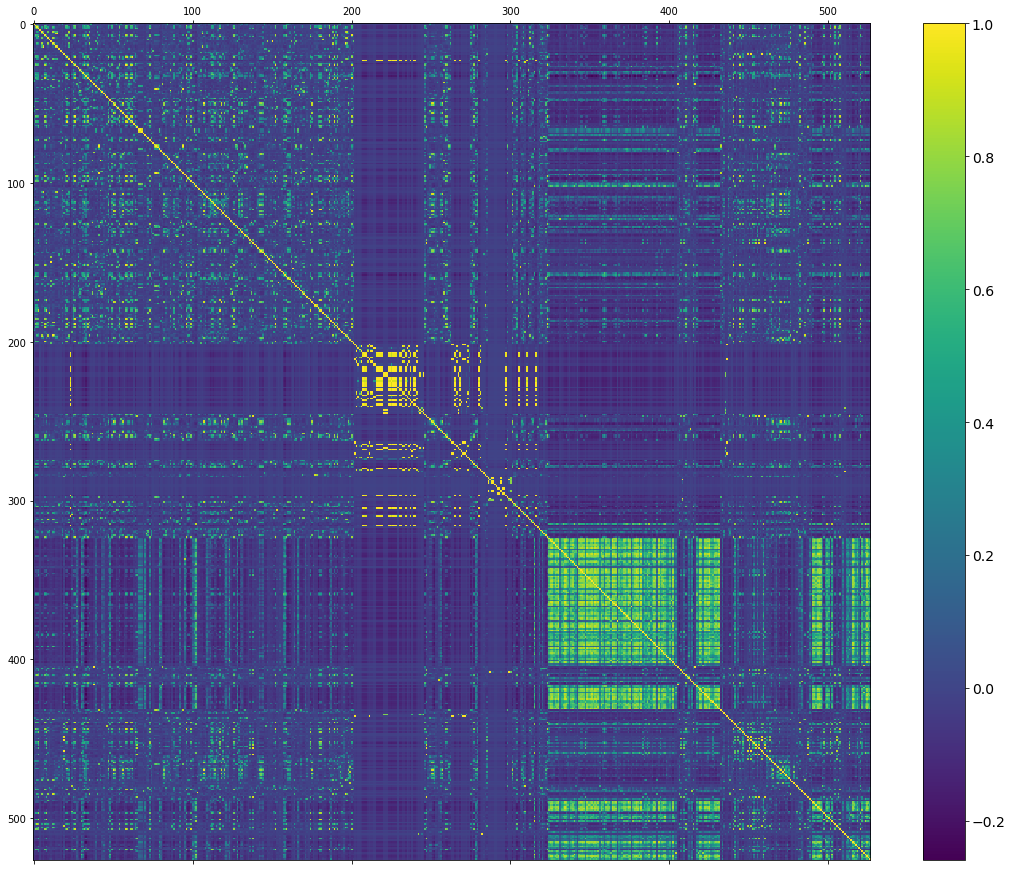

In [261]:
import matplotlib.pyplot as plt


f = plt.figure(figsize=(19, 15))
plt.matshow(item_item_sim_matrix.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Selecting product to make recommendations

In [265]:
productID=14310
top_10_similar_items = list(item_item_sim_matrix.loc[productID].sort_values(ascending=False).iloc[:10].index)
df.loc[
    df['product_id'].isin(top_10_similar_items), 
    ['product_id', 'product_name']
].drop_duplicates().set_index('product_id').loc[top_10_similar_items]

,product_name
product_id,
14310,CERVEZA CORONA 355ML
15913,MAIZ TOSTADO LA ESPECIAL 40 GR
10117,HARINA AREPA NIEVE 500 GR
8225,GASEOSA SPRITE 400 ML
17390,MAQUINA AFEITAR PRESTOBARBA ULTRAGRIP 3
15906,PAPAS MARGARITA LIMON 30 GR
12466,CHOCOLATINA HERSHEY'S COOKIES N' CREME 43 GR
9961,BON BON BUM TROPICAL
8231,PASABOCAS CHEETOS MAXI NATURAL 48 GR


Note: next steps to improve recommendations could be with singular value decomposition (SVD) and Tensorflow 

# Cheers!